In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns 
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### **Import Data**

In [ ]:
train = pd.read_csv('/content/gdrive/My Drive/titanic/train.csv')
test = pd.read_csv('/content/gdrive/My Drive/titanic/test.csv')
combine = [train,test]
#train.head()
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
#looking at data count and null count
train.info()
train.isnull().sum()


In [ ]:
#look at statistical values
train.describe()

In [ ]:
#trick to get numeric data only since describe only gives numeric values
train.describe().columns

Index(['Survived', 'Pclass', 'Age', 'Fare', 'is_alone'], dtype='object')

In [ ]:
# look at numeric and categorical values separately 
df_num = train[['Age','SibSp','Parch','Fare']]
df_cat = train[['Survived','Pclass','Sex','Ticket','Cabin','Embarked']]
df_num.isnull().sum()
df_cat.isnull().sum()


Survived      0
Pclass        0
Sex           0
Ticket        0
Cabin       687
Embarked      2
dtype: int64

In [ ]:
#distributions for all numeric variables 
for i in df_num.columns:
    plt.hist(df_num[i])
    plt.title(i)
    plt.show()

In [ ]:
#take a look at correlation and heatmap of correlation
print(df_num.corr())
sns.heatmap(df_num.corr())

In [ ]:
for i in df_cat.columns:
    sns.barplot(df_cat[i].value_counts().index,df_cat[i].value_counts()).set_title(i)
    plt.show()\

After taking a look at the categorical graphs, we notice that Cabin and Ticket graphs are very messy, and may need to consider deleting them. Ticket numbers are just reference numbers.

Now, we consider deriving new features from existing ones that may help with further analysis. We consider adding a feature for name title, whether a person is alone or not, family size using number of siblings/spouse and number of parents. 

In [ ]:
for dataset in combine:
  dataset['name_title'] = dataset.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
combine

[     PassengerId  Survived  Pclass  ... Cabin Embarked  name_title
 0              1         0       3  ...   NaN        S          Mr
 1              2         1       1  ...   C85        C         Mrs
 2              3         1       3  ...   NaN        S        Miss
 3              4         1       1  ...  C123        S         Mrs
 4              5         0       3  ...   NaN        S          Mr
 ..           ...       ...     ...  ...   ...      ...         ...
 886          887         0       2  ...   NaN        S         Rev
 887          888         1       1  ...   B42        S        Miss
 888          889         0       3  ...   NaN        S        Miss
 889          890         1       1  ...  C148        C          Mr
 890          891         0       3  ...   NaN        Q          Mr
 
 [891 rows x 13 columns],      PassengerId  Pclass  ... Embarked name_title
 0            892       3  ...        Q         Mr
 1            893       3  ...        S        Mrs
 2  

In [ ]:
 for dataset in combine:
  title_names = dataset['name_title'].value_counts() < 10
  dataset['name_title'] = dataset['name_title'].apply(lambda x: 'Rare' if title_names.loc[x] == True else x)
combine

[     PassengerId  Survived  Pclass  ... Cabin Embarked  name_title
 0              1         0       3  ...   NaN        S          Mr
 1              2         1       1  ...   C85        C         Mrs
 2              3         1       3  ...   NaN        S        Miss
 3              4         1       1  ...  C123        S         Mrs
 4              5         0       3  ...   NaN        S          Mr
 ..           ...       ...     ...  ...   ...      ...         ...
 886          887         0       2  ...   NaN        S        Rare
 887          888         1       1  ...   B42        S        Miss
 888          889         0       3  ...   NaN        S        Miss
 889          890         1       1  ...  C148        C          Mr
 890          891         0       3  ...   NaN        Q          Mr
 
 [891 rows x 13 columns],      PassengerId  Pclass  ... Embarked name_title
 0            892       3  ...        Q         Mr
 1            893       3  ...        S        Mrs
 2  

In [ ]:
train['name_title'].value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
Rare       27
Name: name_title, dtype: int64

Now we add the feature is_alone to see whether a person is alone or now. That is if the number of siblings and spouses is 0 and parent is 0.

In [ ]:
for dataset in combine:
  dataset['Family_Size'] = dataset['SibSp'] + dataset['Parch'] + 1 
  dataset['is_alone'] = 0
  dataset.loc[dataset['Family_Size'] == 1, 'is_alone'] = 1

In [ ]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,name_title,Family_Size,is_alone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,2,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,1,1


In [ ]:
print(train.groupby(['Sex', 'Pclass', 'name_title', ])['Age'].median())


Sex     Pclass  name_title
female  1       Miss          30.0
                Mrs           41.5
                Rare          28.5
        2       Miss          24.0
                Mrs           32.0
                Rare          28.0
        3       Miss          18.0
                Mrs           31.0
male    1       Master         4.0
                Mr            40.0
                Rare          49.0
        2       Master         1.0
                Mr            31.0
                Rare          46.5
        3       Master         4.0
                Mr            26.0
Name: Age, dtype: float64


For cabin I first tried to remove it but turns out that it is pretty significant. Most important is whether a person has a cabin or not. Decided to use U for unknown cabin and K for known cabin

In [ ]:
train.Cabin.fillna('Unknown',inplace=True)
test.Cabin.fillna('Unknown',inplace=True)

train['Cabin'] = train['Cabin'].map(lambda x: x[0])
test['Cabin'] = test['Cabin'].map(lambda x: x[0])

train['Cabin'] = train['Cabin'].map(lambda x: 'K' if str(x) != 'U' else x[0])
test['Cabin'] = test['Cabin'].map(lambda x: 'K' if str(x) != 'U' else x[0])

In [ ]:
test['Cabin'].sort_values()

208    K
96     K
177    K
178    K
179    K
      ..
153    U
152    U
151    U
162    U
417    U
Name: Cabin, Length: 418, dtype: object

Now, plotting the histogram to see the distribution of the cabin letters

(array([687.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 204.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

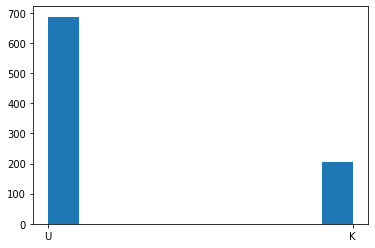

In [ ]:
plt.hist(train['Cabin'])

(array([327.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  91.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

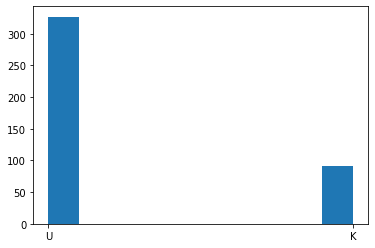

In [ ]:
plt.hist(test['Cabin'])

Histogram excluding unknown to compare other cabins

(array([59., 32.,  4.,  0., 33., 15.,  0., 47., 13.,  1.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <a list of 10 Patch objects>)

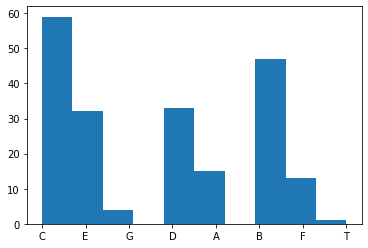

In [ ]:
plt.hist(train[train.Cabin != 'U']['Cabin'])

In [ ]:
#deleting PassengerId, Name, Ticket
for dataset in combine:
  #dataset.drop(['PassengerId','Name','Ticket','Cabin','SibSp','Parch','Family_Size'], inplace = True, axis = 1)
  dataset.drop(['PassengerId','Name','Ticket','SibSp','Parch'], inplace = True, axis = 1)


In [ ]:
for dataset in combine:
  s = dataset.isnull().sum()
  print(s)

Survived         0
Pclass           0
Sex              0
Age            177
Fare             0
Cabin            0
Embarked         2
name_title       0
Family_Size      0
is_alone         0
dtype: int64
Pclass          0
Sex             0
Age            86
Fare            1
Cabin           0
Embarked        0
name_title      0
Family_Size     0
is_alone        0
dtype: int64


Filling in the missing values with appropriate estimators

Instead of using median age of total passengers, it would be better to group them by sex, class, and title to get the median for each group

In [ ]:
train['Age'] = train.groupby(['Sex','Pclass','name_title'])['Age'].apply(lambda x: x.fillna(x.median()))
test['Age'] = test.groupby(['Sex','Pclass','name_title'])['Age'].apply(lambda x: x.fillna(x.median()))
for dataset in combine:
  dataset['Age'].fillna(dataset['Age'].median(),inplace = True)
  dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)
  dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)


In [ ]:
test['Age'].isnull().sum()

0

Now we can see that there are no missing values in the dataset.

In [ ]:
for dataset in combine:
  s = dataset.isnull().sum()
  print(s)

Survived       0
Pclass         0
Sex            0
Age            0
Fare           0
Cabin          0
Embarked       0
name_title     0
Family_Size    0
is_alone       0
dtype: int64
Pclass         0
Sex            0
Age            0
Fare           0
Cabin          0
Embarked       0
name_title     0
Family_Size    0
is_alone       0
dtype: int64


In [ ]:
train.head()


,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,name_title,Family_Size,is_alone
0,0,3,male,22.0,7.2500,U,S,Mr,2,0
1,1,1,female,38.0,71.2833,K,C,Mrs,2,0
2,1,3,female,26.0,7.9250,U,S,Miss,1,1
3,1,1,female,35.0,53.1000,K,S,Mrs,2,0
4,0,3,male,35.0,8.0500,U,S,Mr,1,1


In [ ]:
train_dummy = pd.get_dummies(train, columns = ['Sex','Cabin','Embarked','name_title'])
test_dummy = pd.get_dummies(test, columns = ['Sex','Cabin','Embarked','name_title'])
combined_dummy = [train_dummy,test_dummy]
combined_dummy

[     Survived  Pclass   Age  ...  name_title_Mr  name_title_Mrs  name_title_Rare
 0           0       3  22.0  ...              1               0                0
 1           1       1  38.0  ...              0               1                0
 2           1       3  26.0  ...              0               0                0
 3           1       1  35.0  ...              0               1                0
 4           0       3  35.0  ...              1               0                0
 ..        ...     ...   ...  ...            ...             ...              ...
 886         0       2  27.0  ...              0               0                1
 887         1       1  19.0  ...              0               0                0
 888         0       3  18.0  ...              0               0                0
 889         1       1  26.0  ...              1               0                0
 890         0       3  32.0  ...              1               0                0
 
 [891 rows x 1

In [ ]:
train_dummy.head()

,Survived,Pclass,Age,Fare,Family_Size,is_alone,Sex_female,Sex_male,Cabin_K,Cabin_U,Embarked_C,Embarked_Q,Embarked_S,name_title_Master,name_title_Miss,name_title_Mr,name_title_Mrs,name_title_Rare
0,0,3,22.0,7.2500,2,0,0,1,0,1,0,0,1,0,0,1,0,0
1,1,1,38.0,71.2833,2,0,1,0,1,0,1,0,0,0,0,0,1,0
2,1,3,26.0,7.9250,1,1,1,0,0,1,0,0,1,0,1,0,0,0
3,1,1,35.0,53.1000,2,0,1,0,1,0,0,0,1,0,0,0,1,0
4,0,3,35.0,8.0500,1,1,0,1,0,1,0,0,1,0,0,1,0,0


In [ ]:
test_dummy.head()

,Pclass,Age,Fare,Family_Size,is_alone,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_U,Embarked_C,Embarked_Q,Embarked_S,name_title_Master,name_title_Miss,name_title_Mr,name_title_Mrs,name_title_Rare
0,3,34.5,7.8292,1,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0
1,3,47.0,7.0000,2,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0
2,2,62.0,9.6875,1,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0
3,3,27.0,8.6625,1,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0
4,3,22.0,12.2875,3,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0


In [ ]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics


X_train = train_dummy.drop("Survived", axis=1)
Y_train = train_dummy["Survived"]
X_test  = test_dummy.copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 17), (891,), (418, 17))

In [ ]:
X_train

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


83.73

In [ ]:
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

84.96

In [ ]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

98.77

In [ ]:
Y_pred

array([0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [ ]:
test_pid = pd.read_csv('/content/gdrive/My Drive/titanic/test.csv')
test_pid

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [ ]:
submission = pd.DataFrame({
        "PassengerId": test_pid["PassengerId"],
        "Survived": Y_pred
    })
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [ ]:
submission.to_csv('/content/gdrive/My Drive/titanic/submission.csv', index=False)